# Model Regression for Exposure At Default

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

%config IPCompleter.greedy=True

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

In [2]:

df = pd.read_pickle('../../02_Data/03_Work/df_board_ead.pickle')
x = df.drop(columns='target_ead')
y = df.target_ead



## MODEL

In [6]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

In [9]:
pipe = Pipeline([('algorythm',Ridge())])

grid = [      
        {'algorythm': [Ridge()],
         'algorythm__alpha': list(np.arange(0.1,1.1,0.1))},
        
        {'algorythm': [Lasso()],
         'algorythm__alpha': list(np.arange(0.1,1.1,0.1))},
    
        {'algorythm': [HistGradientBoostingRegressor(min_samples_leaf = 100, scoring = 'neg_mean_absolute_percentage_error')],
         'algorythm__learning_rate': [0.01,0.025,0.05,0.1],
         'algorythm__max_iter': [50,100,200],
         'algorythm__max_depth': [5,10,20],
         'algorythm__l2_regularization': [0,0.25,0.5,0.75,1]}
       ]

#### Optimize hyperparameters

In [11]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 3, 
                           scoring = 'neg_mean_absolute_error',
                           verbose = 0,
                           n_jobs = -1)

model = grid_search.fit(train_x,train_y)

In [12]:
output = pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').reset_index(drop=True).head(10)
output

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorythm,param_algorythm__alpha,param_algorythm__l2_regularization,param_algorythm__learning_rate,param_algorythm__max_depth,param_algorythm__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,22.00,0.20,0.54,0.00,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.75,0.10,20,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.24,-0.24,-0.23,-0.24,0.00,1
1,20.84,0.26,0.53,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0,0.10,10,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.23,-0.24,-0.24,-0.24,0.00,2
2,20.95,0.12,0.56,0.02,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.50,0.10,10,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.23,-0.24,-0.24,-0.24,0.00,3
3,21.66,0.25,0.55,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.25,0.10,20,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.23,-0.24,-0.24,-0.24,0.00,4
4,18.36,0.15,0.28,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,1,0.10,10,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.24,-0.23,-0.23,-0.24,0.00,5
5,20.60,0.33,0.57,0.07,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.25,0.10,10,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.23,-0.24,-0.24,-0.24,0.00,6
6,21.99,0.63,0.55,0.03,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0,0.10,20,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.24,-0.23,-0.24,-0.24,0.00,7
7,21.49,0.24,0.54,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.50,0.10,20,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.24,-0.24,-0.24,-0.24,0.00,8
8,15.49,0.22,0.25,0.00,HistGradientBoostingRegressor(min_samples_leaf...,NaN,1,0.10,20,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.24,-0.24,-0.24,-0.24,0.00,9
9,20.51,0.51,0.53,0.01,HistGradientBoostingRegressor(min_samples_leaf...,NaN,0.75,0.10,10,200,{'algorythm': HistGradientBoostingRegressor(mi...,-0.24,-0.24,-0.24,-0.24,0.00,10


In [13]:
# result is very similar for the first configurations
# we choose the first one for simplicity

In [14]:
model_ead = HistGradientBoostingRegressor(learning_rate = 0.1,
                                          max_iter = 200,
                                          max_depth = 10,
                                          min_samples_leaf = 100,
                                          scoring = 'neg_mean_absolute_percentage_error',
                                          l2_regularization = 0.75)
model_ead.fit(train_x,train_y)

HistGradientBoostingRegressor(l2_regularization=0.75, max_depth=10,
                              max_iter=200, min_samples_leaf=100,
                              scoring='neg_mean_absolute_percentage_error')

### Evaluate

In [17]:
pred = model_ead.predict(val_x)

In [19]:
# correct max and min
pred = np.where(pred < 0, 0, pred)
pred = np.where(pred > 1, 1, pred)

In [21]:
mean_absolute_error(val_y, pred)

0.23280119010598735

### Report

In [22]:
check_validation = pd.DataFrame({'true_EAD':val_y, 'pred_EAD':pred})
check_validation

,true_EAD,pred_EAD
client_id,,
41760122,0.00,0.18
131377868,0.85,0.63
1474553,0.81,0.10
110759254,0.44,0.16
70861213,0.00,0.23
...,...,...
64969311,0.00,0.06
87014217,0.55,0.33
113493957,0.00,0.47


In [24]:
check_validation.corr()

,true_EAD,pred_EAD
true_EAD,1.00,0.64
pred_EAD,0.64,1.00


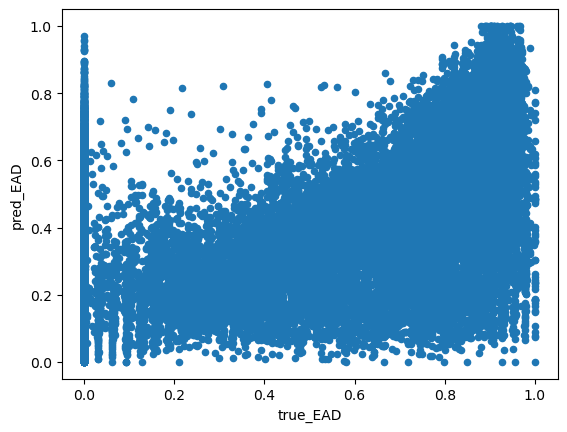

In [27]:
check_validation.plot.scatter(x='true_EAD',y='pred_EAD');

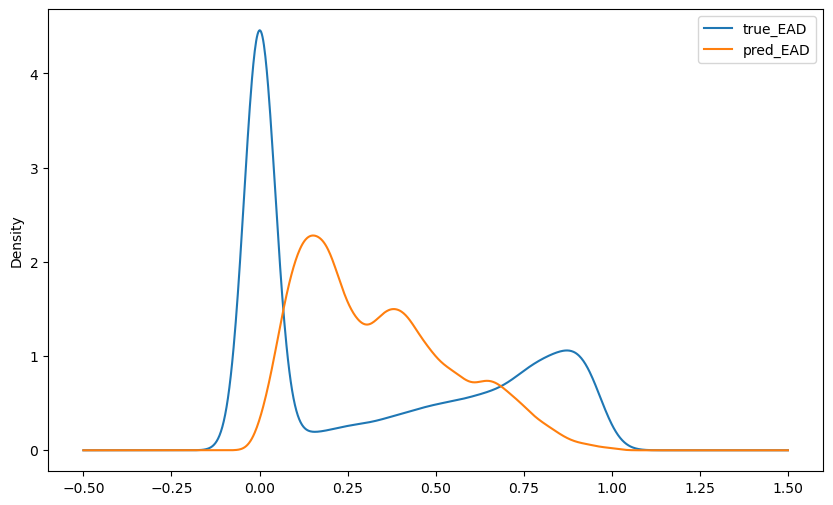

In [29]:
check_validation.plot.density(figsize = (10,6));